In [ ]:
! pip install yfinance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import warnings
from tensorflow.keras.utils import get_file
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.layers import SimpleRNN

In [ ]:
def data_to_X_y(temp, window_size=5):
  data_as_np=temp.to_numpy()
  X = []
  y = []
  for i in range(len(data_as_np)-window_size):
    row = [[a] for a in data_as_np[i:i+5]]
    X.append(row)
    label = data_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
def train_test_val_split(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  print('Train Set: ', X_train.shape, y_train.shape)
  print('Test Set: ', X_test.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

In [ ]:
# Performance Metric
def metric(model, X_test, y_test):
  yhat=model.predict(X_test)
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]

In [ ]:
score_dict={}

In [ ]:
def permute_time_series(data, column_name):
    permuted_data = data.copy()
    permuted_data[column_name] = np.random.permutation(permuted_data[column_name])
    return permuted_data


# **Climate Data**

In [ ]:
# Download and load the dataset
zip_path = get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
data = pd.read_csv(csv_path)

13568290/13568290 [==============================] - 0s 0us/step


In [ ]:
data.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1


In [ ]:
data.index = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')
permuted_data = permute_time_series(data, 'T (degC)')
temp = permuted_data['T (degC)']

In [ ]:
WINDOW_SIZE=5
X, y=data_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (294382, 5, 1) (294382,)
Test Set:  (126164, 5, 1) (126164,)


## **LSTM**

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(24))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
9200/9200 [==============================] - 117s 12ms/step - loss: 71.1005 - val_loss: 72.2208
Epoch 2/10
9200/9200 [==============================] - 101s 11ms/step - loss: 70.8127 - val_loss: 72.1272
Epoch 3/10
9200/9200 [==============================] - 95s 10ms/step - loss: 70.7640 - val_loss: 72.0357
Epoch 4/10
9200/9200 [==============================] - 104s 11ms/step - loss: 70.7380 - val_loss: 71.9613
Epoch 5/10
9200/9200 [==============================] - 96s 10ms/step - loss: 70.7190 - val_loss: 71.9087
Epoch 6/10
9200/9200 [==============================] - 107s 12ms/step - loss: 70.7051 - val_loss: 71.8708
Epoch 7/10
9200/9200 [==============================] - 116s 13ms/step - loss: 70.6943 - val_loss: 71.8360
Epoch 8/10
9200/9200 [==============================] - 103s 11ms/step - loss: 70.6841 - val_loss: 71.8195
Epoch 9/10
9200/9200 [==============================] - 98s 11ms/step - loss: 70.6731 - val_loss: 71.8036
Epoch 10/10
9200/9200 [=================

In [ ]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_Climate']= LSTM_

3943/3943 [==============================] - 14s 4ms/step
RMSE 8.472934241567758
MSE 71.7906146619314
MAE 6.903640835884539


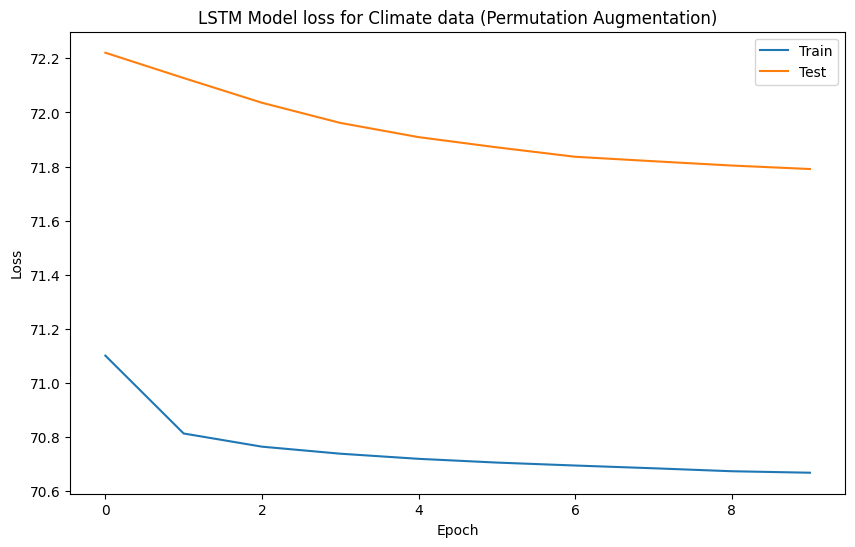

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for Climate data (Permutation Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

9200/9200 [==============================] - 33s 4ms/step


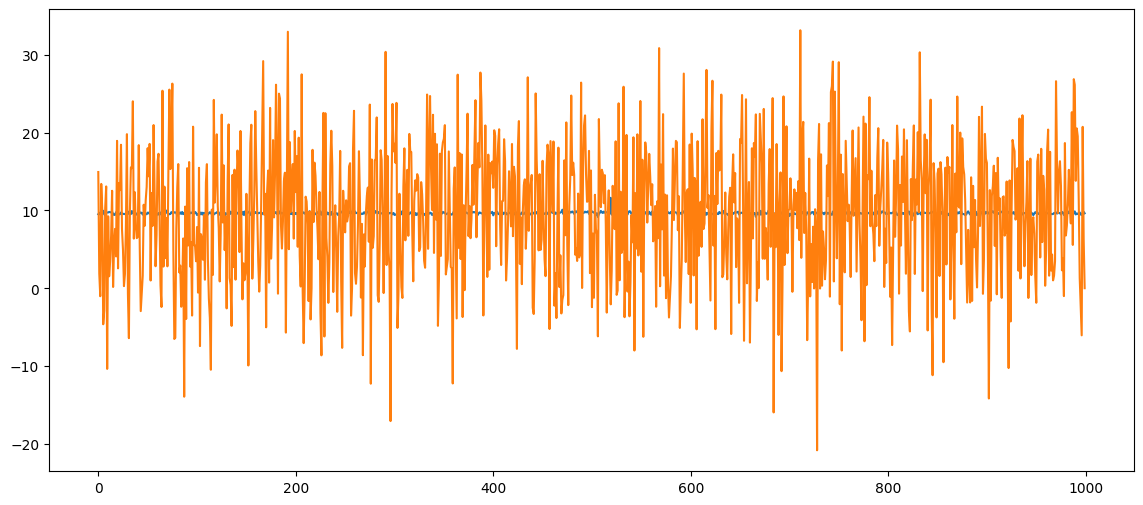

In [ ]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
train_results.index=temp.head(294382).index
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

3943/3943 [==============================] - 14s 4ms/step


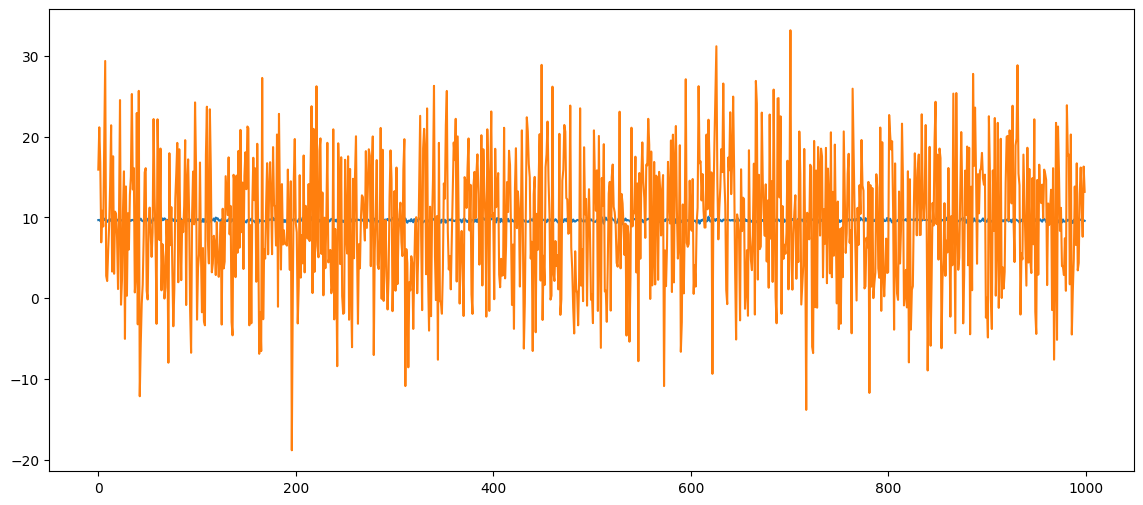

In [ ]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
test_results.index=temp.tail(126164).index
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **RNN**

In [ ]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(temp, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_Climate']= arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

RMSE 8.469609430983828
MSE 71.7342839134102
MAE 6.901157270426968


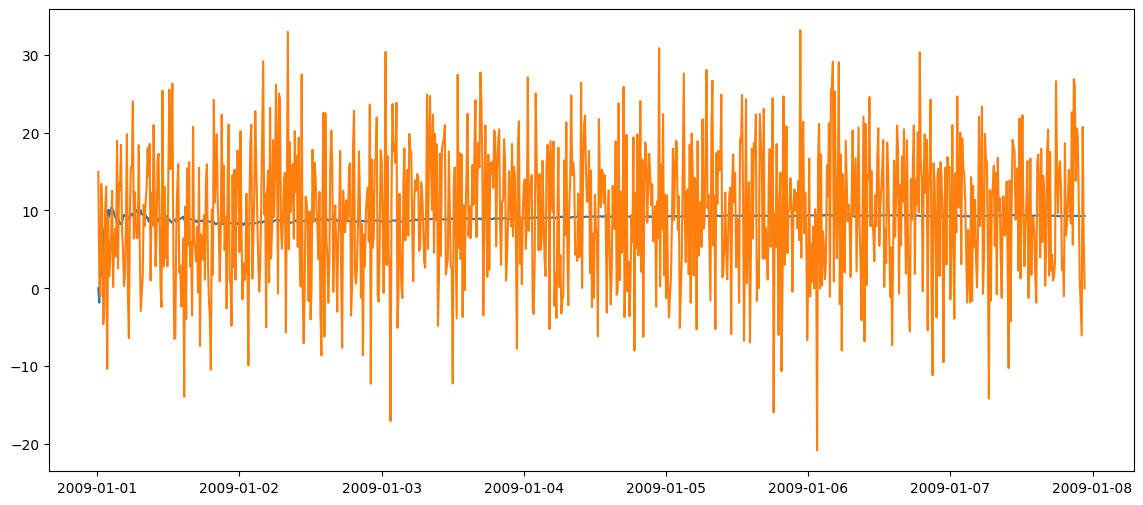

In [ ]:

plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

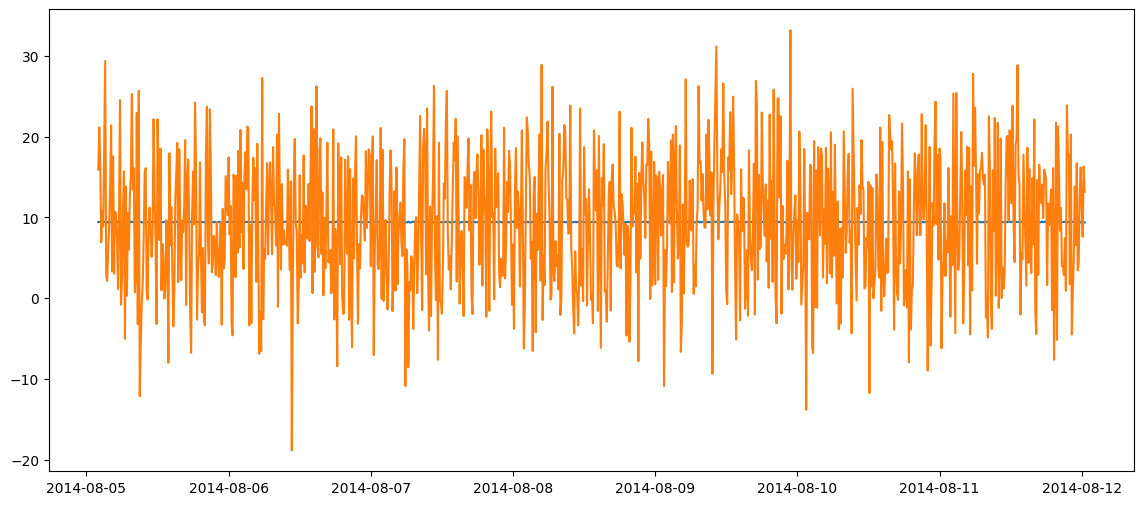

In [ ]:

plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **Stacking**

In [ ]:
from sklearn.linear_model import LinearRegression
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_Climate']= stacked_

RMSE 8.470172507665986
MSE 71.7438223096207
MAE 6.901494208711202


# **Crypto Dataset (USDT)**

In [ ]:
# Get bitcoin data
data=  yf.Ticker("USDT-USD").history(interval='1d', start='2000-01-01', end='2022-12-31').reset_index()
data.head(2)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-11-09 00:00:00+00:00,1.01087,1.01327,0.996515,1.00818,358188000,0.0,0.0
1,2017-11-10 00:00:00+00:00,1.00650,1.02423,0.995486,1.00601,756446016,0.0,0.0


In [ ]:
data.index = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S')
permuted_data = permute_time_series(data, 'Close')
usdt = permuted_data['Close']

In [ ]:
X, y=data_to_X_y(usdt, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (1311, 5, 1) (1311,)
Test Set:  (562, 5, 1) (562,)


## **LSTM**

In [ ]:
model = Sequential()
model.add(LSTM(32, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
41/41 [==============================] - 2s 11ms/step - loss: 0.9571 - val_loss: 0.6584
Epoch 2/10
41/41 [==============================] - 0s 5ms/step - loss: 0.4287 - val_loss: 0.1945
Epoch 3/10
41/41 [==============================] - 0s 5ms/step - loss: 0.0505 - val_loss: 0.0033
Epoch 4/10
41/41 [==============================] - 0s 4ms/step - loss: 5.9027e-04 - val_loss: 5.4493e-05
Epoch 5/10
41/41 [==============================] - 0s 5ms/step - loss: 4.0854e-05 - val_loss: 4.9135e-05
Epoch 6/10
41/41 [==============================] - 0s 5ms/step - loss: 3.7562e-05 - val_loss: 4.8489e-05
Epoch 7/10
41/41 [==============================] - 0s 5ms/step - loss: 3.7459e-05 - val_loss: 4.8488e-05
Epoch 8/10
41/41 [==============================] - 0s 4ms/step - loss: 3.7463e-05 - val_loss: 4.8489e-05
Epoch 9/10
41/41 [==============================] - 0s 5ms/step - loss: 3.7469e-05 - val_loss: 4.8490e-05
Epoch 10/10
41/41 [==============================] - 0s 6ms/step - lo

In [ ]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_USDT']= LSTM_

18/18 [==============================] - 0s 3ms/step
RMSE 0.006963592755557469
MSE 4.849162406525247e-05
MAE 0.004186005885066511


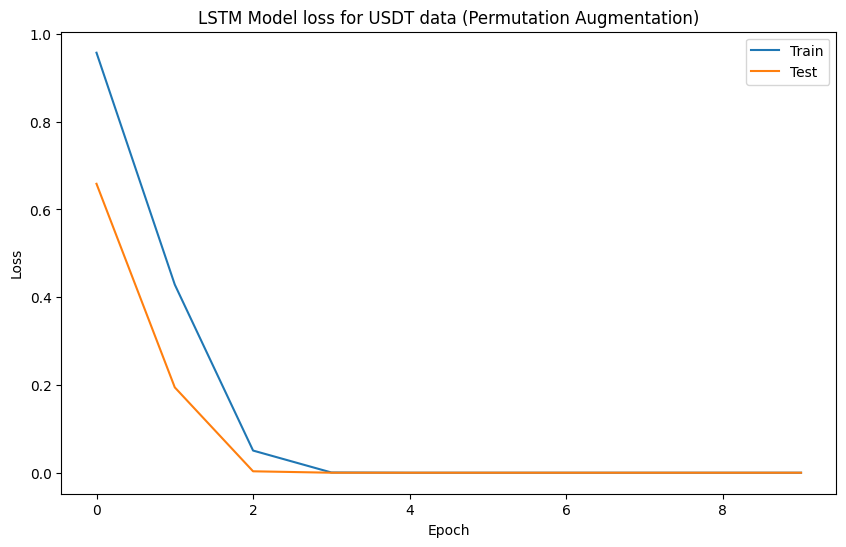

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for USDT data (Permutation Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

41/41 [==============================] - 0s 3ms/step


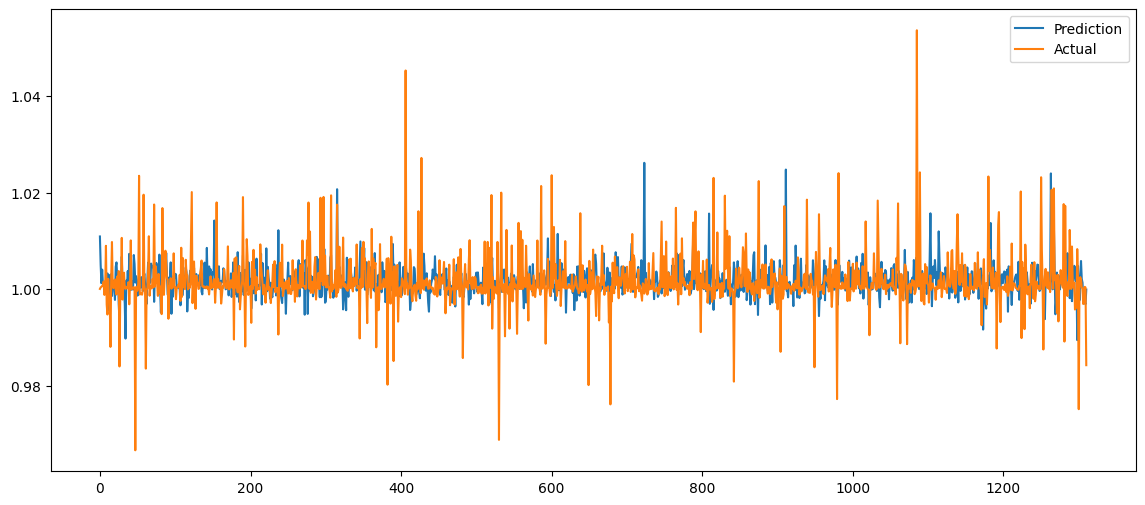

In [ ]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
train_results.index=usdt.head(1311).index
plt.figure(figsize=(14, 6))
plt.plot(train_results['Train Predictions'], label='Prediction')
plt.plot(train_results['Actuals'], label='Actual')
plt.legend()

18/18 [==============================] - 0s 2ms/step


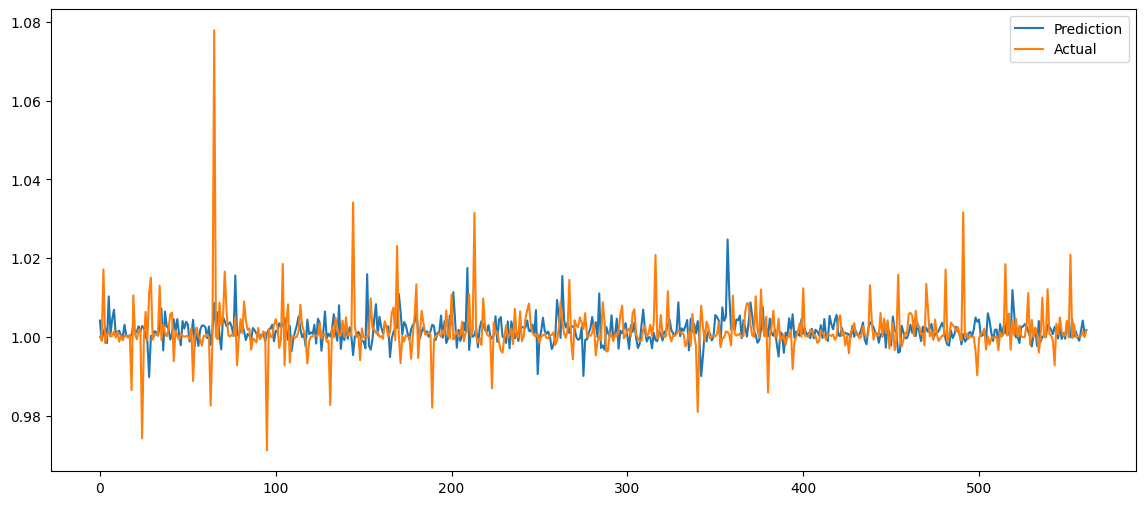

In [ ]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
test_results.index=usdt.tail(562).index
plt.figure(figsize=(14, 6))
plt.plot(test_results['Test Predictions'], label='Prediction')
plt.plot(test_results['Actuals'], label='Actual')
plt.legend()

## **RNN**

In [ ]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(usdt, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_USDT']= arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE 0.006183658726513855
MSE 3.823763524599095e-05
MAE 0.00319374774252786


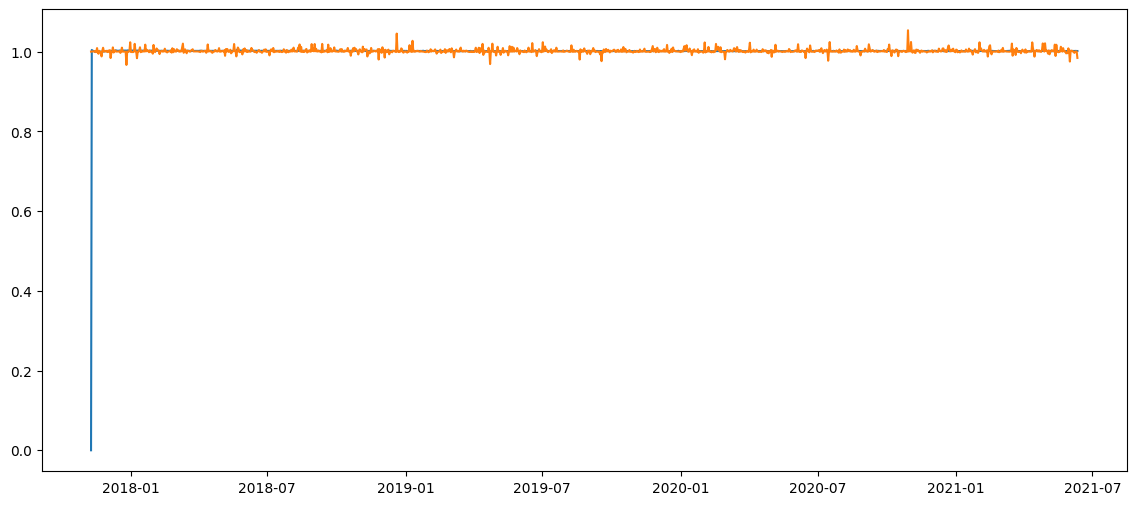

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

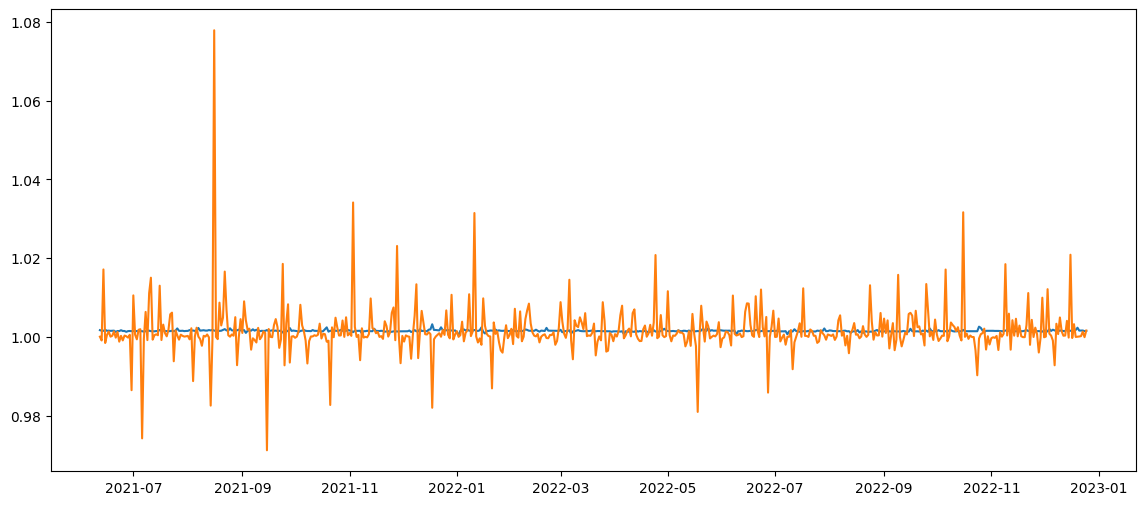

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

## **Stacking**

In [ ]:
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_USDT']= stacked_

RMSE 0.006177894788660053
MSE 3.8166384019753036e-05
MAE 0.003220299111552671


# **Plant Sensor Data**

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/measures.csv')
df.head()

,mp,temperature,humidity,moisture,light,date,time
0,n1,24.7,57.9,1995,0.0,2022-09-15,00:00:04
1,n1,24.7,58.0,1991,0.0,2022-09-15,00:00:09
2,n1,24.7,58.2,1994,0.0,2022-09-15,00:00:14
3,n1,24.6,58.0,1993,0.0,2022-09-15,00:00:19
4,n1,24.6,58.0,1986,0.0,2022-09-15,00:00:25


In [ ]:
df.date=pd.to_datetime(df['date'] + ' ' + df['time'])
df.index = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')

In [ ]:
permuted_data = permute_time_series(df, 'humidity')
humidity = permuted_data['humidity']

In [ ]:
WINDOW_SIZE=5
X, y=data_to_X_y(humidity, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (163782, 5, 1) (163782,)
Test Set:  (70193, 5, 1) (70193,)


## **LSTM**

In [ ]:
model = Sequential()
model.add(LSTM(16, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
5119/5119 [==============================] - 25s 5ms/step - loss: 261.2830 - val_loss: 238.7225
Epoch 2/10
5119/5119 [==============================] - 23s 5ms/step - loss: 243.2011 - val_loss: 236.9482
Epoch 3/10
5119/5119 [==============================] - 22s 4ms/step - loss: 242.6149 - val_loss: 236.8052
Epoch 4/10
5119/5119 [==============================] - 22s 4ms/step - loss: 242.1501 - val_loss: 236.6373
Epoch 5/10
5119/5119 [==============================] - 23s 5ms/step - loss: 241.8982 - val_loss: 236.2903
Epoch 6/10
5119/5119 [==============================] - 24s 5ms/step - loss: 241.7338 - val_loss: 236.1609
Epoch 7/10
5119/5119 [==============================] - 23s 5ms/step - loss: 241.6724 - val_loss: 236.1725
Epoch 8/10
5119/5119 [==============================] - 23s 5ms/step - loss: 241.6569 - val_loss: 236.1010
Epoch 9/10
5119/5119 [==============================] - 22s 4ms/step - loss: 241.6552 - val_loss: 236.4055
Epoch 10/10
5119/5119 [==============

In [ ]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_Humidty']= LSTM_

2194/2194 [==============================] - 5s 2ms/step
RMSE 15.36358211216797
MSE 236.0396553173276
MAE 11.673955864430987


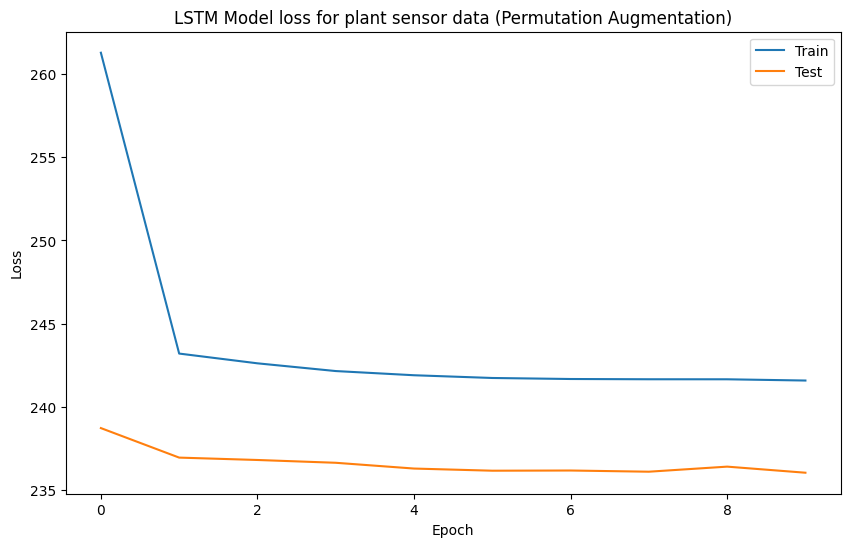

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for plant sensor data (Permutation Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

5119/5119 [==============================] - 9s 2ms/step


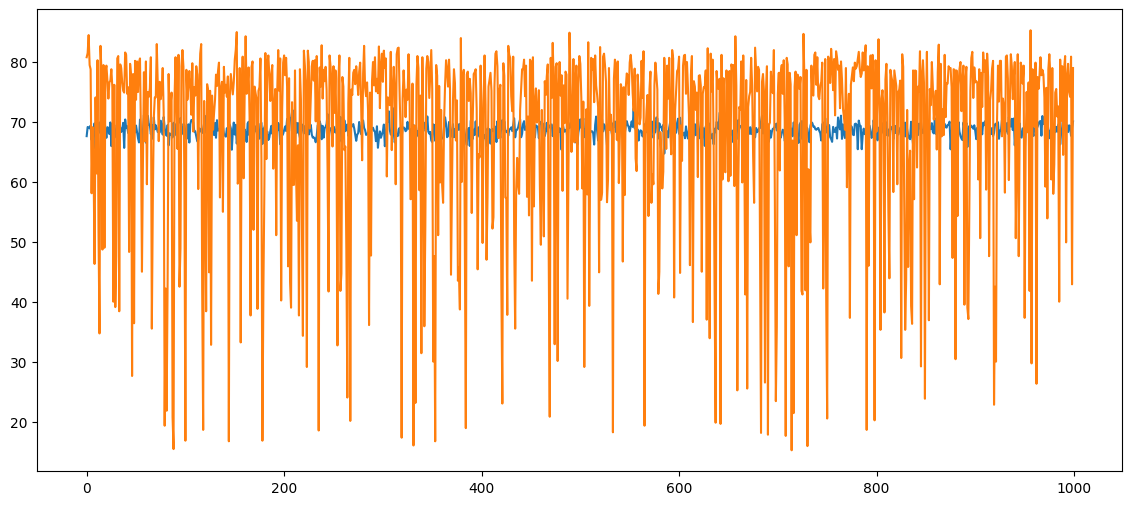

In [ ]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
train_results.index=humidity.head(163782).index
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

2194/2194 [==============================] - 4s 2ms/step


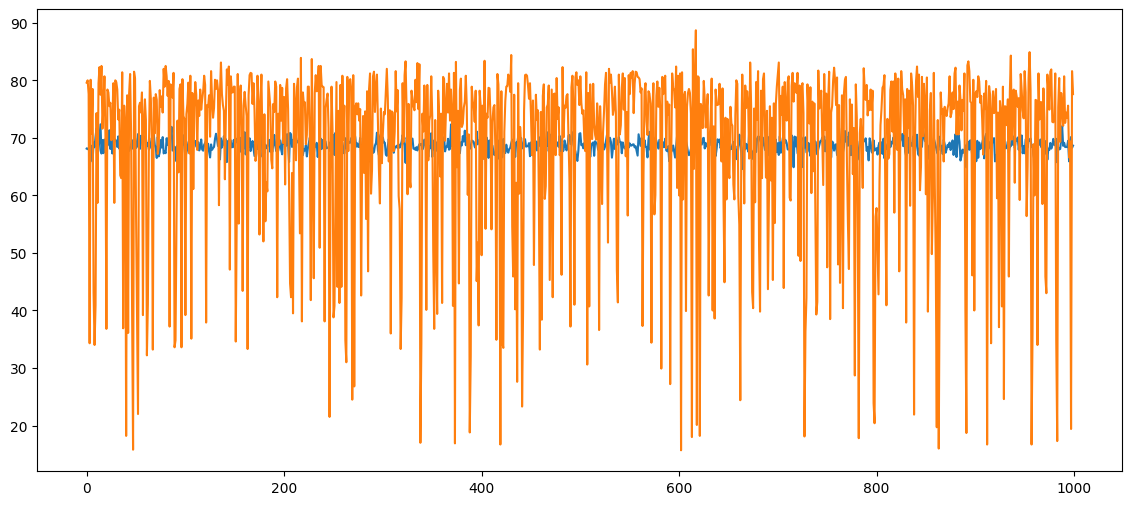

In [ ]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
test_results.index=humidity.tail(70193).index
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **RNN**

In [ ]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(humidity, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_Humidity']= arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE 15.435340229059817
MSE 238.24972798683237
MAE 11.642631212312356


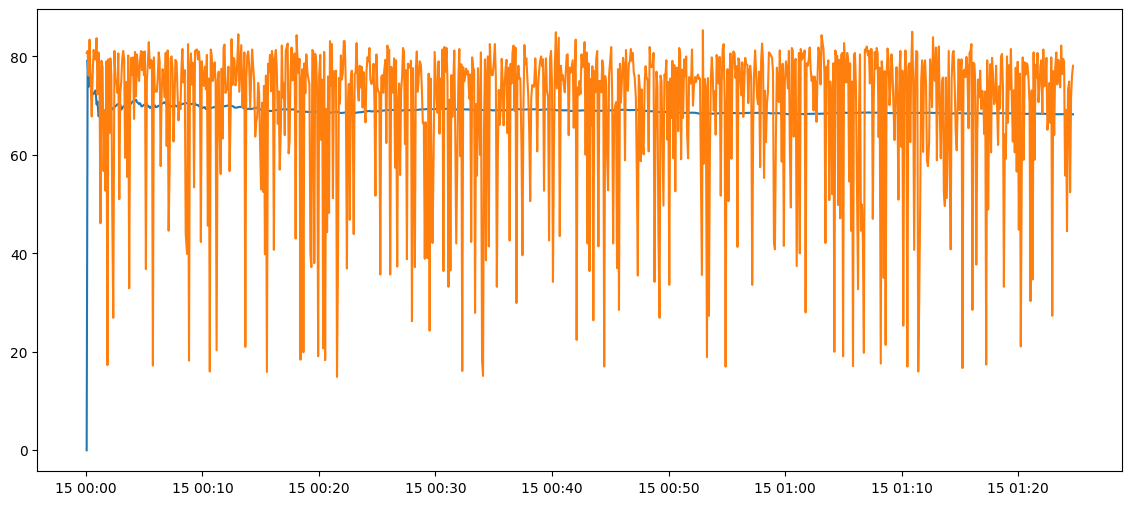

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

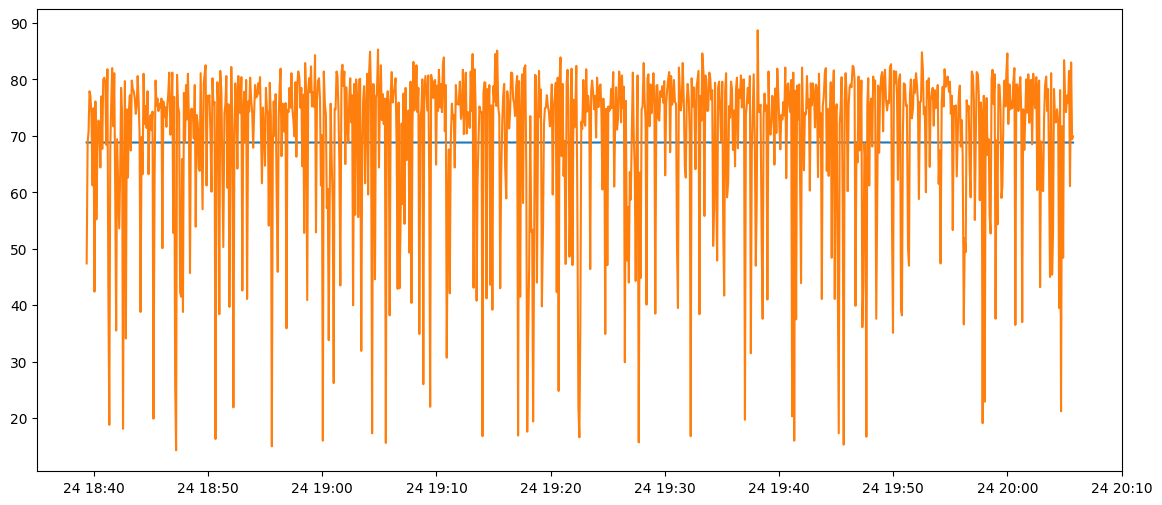

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **Stacking**

In [ ]:
from sklearn.linear_model import LinearRegression
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_Humidity']= stacked_

RMSE 15.321554765938226
MSE 234.75004044564434
MAE 11.602740425897707


# **Results**

In [ ]:
Result=pd.DataFrame(score_dict).T
Result.columns=['RMSE', 'MSE', 'MAE']
Result[ 'Dat']=Result.index.str.split('_')
Result['Data']=Result[ 'Dat'].str[1]
Result['Model']=Result['Dat'].str[0]
Result.drop('Dat', axis=1, inplace=True)
Result=Result.set_index('Data')
Result=Result[['Model', 'RMSE', 'MSE', 'MAE']]
Result.to_csv('/content/drive/MyDrive/New TS DA/Permutation_Augmentation.csv')